In [165]:
"""
STEPS
1. Find the image collection corresponding to LANDSAT7 data
2. Filter the collection to January 2005 outside of the rainy season
3. Load in village location data
4. Create function to load in lat and long data from each village row
5. Function creates EE.Geometry.Point object from each lat and long and sets a buffer of a certain radius
6. Function loads in all bands of data from that image and inputs it into correspond row of new dataframe
7. Function adds village category to each row
8. Train neural network to predict whether there is a village, destroyed village, or no settlmment in the image
"""

'\nSTEPS\n1. Find the image collection corresponding to LANDSAT7 data\n2. Filter the collection to January 2005 outside of the rainy season\n3. Load in village location data\n4. Create function to load in lat and long data from each village row\n5. Function creates EE.Geometry.Point object from each lat and long and sets a buffer of a certain radius\n6. Function loads in all bands of data from that image and inputs it into correspond row of new dataframe\n7. Function adds village category to each row\n8. Train neural network to predict whether there is a village, destroyed village, or no settlmment in the image\n'

In [166]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [167]:
import ee
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [168]:
#Authenticaing API access
ee.Authenticate()

True

In [169]:
#Initialzing Earth Engine
ee.Initialize(project='sudan-1234')

In [170]:
#loading in the LANDSAT7 image data
COPERNICUS = ee.ImageCollection('COPERNICUS/S2_HARMONIZED')

In [171]:
#loading in village data
village_data = pd.read_csv('../content/drive/My Drive/Sudan_village_data/village_data.csv')

In [172]:
village_data.head()

,NAME,LATITUDE,LAT_DD,LONGITUDE,LONG_DD,STATUS,STRUCTURES,YR_CONFIRM,APROX_STR1,APROX_STR2,YR_RANGE1,YR_RANGE2,SEC_TOWN
0,NaN,131857,13.315833,0244942,24.828333,DAMAGED,~25 of ~50,NaN,25.0,50.0,NaN,NaN,NaN
1,DOLA,131905,13.318056,0245404,24.901111,DESTROYED,~200 of ~200,2008/2009,200.0,200.0,2008.0,2009.0,NaN
2,LABABIS,131613,13.270278,0244822,24.806111,DESTROYED,~100 of ~100,NaN,100.0,100.0,NaN,NaN,NaN
3,SURRI,131740,13.294444,0245013,24.836944,DESTROYED,~250 of ~300,2004,250.0,300.0,2004.0,2004.0,NaN
4,NANOREE,131813,13.303611,0245206,24.868333,DESTROYED,~75 of ~100,2003/2004,75.0,100.0,2003.0,2004.0,NaN


In [173]:
#add id column
village_data['ID'] = village_data.index

In [174]:
#dropping irrelevant columns
village_data = village_data[["ID","LAT_DD", "LONG_DD", "STATUS", "YR_CONFIRM"]]

In [175]:
village_data = village_data[:100]

In [176]:
#spliting yr_confirm into a list of multiple years
village_data['YR_CONFIRM'] = village_data['YR_CONFIRM'].str.split('/')

#selecting the last year
village_data['YR_CONFIRM'] = village_data['YR_CONFIRM'].apply(lambda x: x if x is np.nan else x[-1])


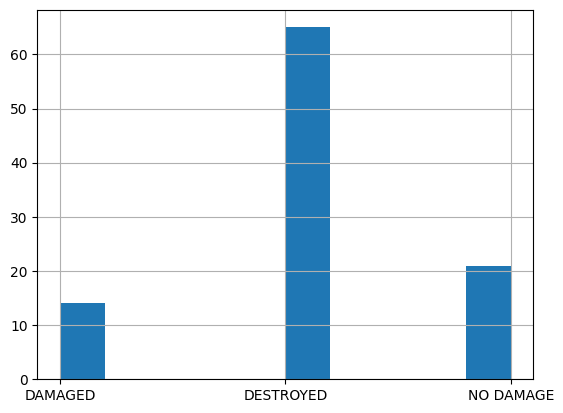

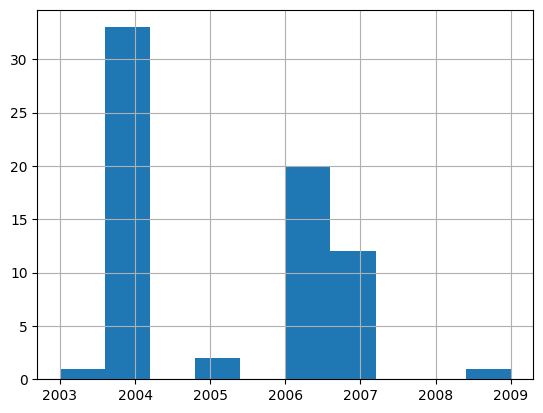

In [177]:
#plotting histograms of categorial data
village_data['STATUS'].hist()
plt.show()

village_data['YR_CONFIRM'] = village_data['YR_CONFIRM'].astype(float)
village_data['YR_CONFIRM'].hist()
plt.show()

In [178]:
#value counts for YR_CONFIRM
village_data['YR_CONFIRM'].value_counts()

,count
YR_CONFIRM,
2004.0,33
2006.0,20
2007.0,12
2005.0,2
2009.0,1
2003.0,1


In [179]:
village_data["STATUS"].value_counts()

,count
STATUS,
DESTROYED,65
NO DAMAGE,21
DAMAGED,14


In [180]:
#seperating the village data into one dataframe of of damaged and destroyed villages and one of undamaged villages
damaged_villages = village_data[village_data['STATUS'].isin(["DAMAGED", "DESTROYED"])]
undamaged_villages = village_data[village_data['STATUS'] == "NO DAMAGE"]

In [181]:
#merging status of damaged villages into one category called "DAMAGED"
damaged_villages['STATUS'] = damaged_villages['STATUS'].apply(lambda x: 'DAMAGED')

<ipython-input-181-69f38f24abc1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  damaged_villages['STATUS'] = damaged_villages['STATUS'].apply(lambda x: 'DAMAGED')


In [182]:
#limiting damaged villages to be after 2006
damaged_villages = damaged_villages[damaged_villages['YR_CONFIRM'] >= 2006]


<Axes: >

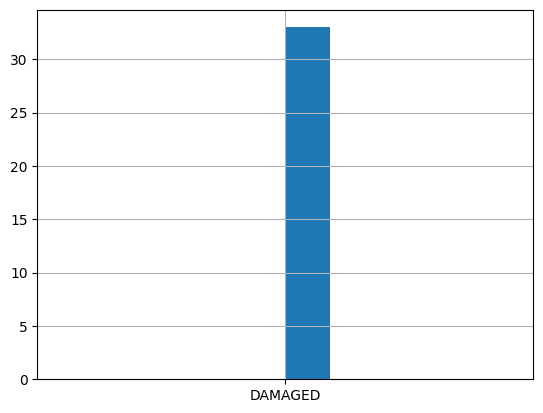

In [183]:
damaged_villages["STATUS"].hist()

In [184]:
print(len(damaged_villages))
print(len(undamaged_villages))

33
21


In [185]:
#speicifying year 2017
start_date = '2017-04-01'
end_date = '2017-12-31'

COPERNICUS = COPERNICUS.filterDate(start_date, end_date)

In [186]:
#creates a feature collection of all the village data from LANDSAT7 data, geometry box with 50 meter buffer around coordinates for village and two properties: village status (No damage, or damage) and id

no_damage = ee.FeatureCollection(undamaged_villages.apply(lambda x: ee.Feature(ee.Geometry.BBox(x['LONG_DD']-0.0005, x['LAT_DD']-0.0005, x['LONG_DD']+0.0005, x['LAT_DD']+0.0005), {'STATUS': 'NO DAMAGE', 'ID': x['ID']}), axis=1).tolist())
damaged = ee.FeatureCollection(damaged_villages.apply(lambda x: ee.Feature(ee.Geometry.BBox(x['LONG_DD']-0.0005, x['LAT_DD']-0.0005, x['LONG_DD']+0.0005, x['LAT_DD']+0.0005), {'STATUS': 'DAMAGED', 'ID': x['ID']}), axis=1).tolist())



In [187]:
#combine into single feature collection
villages = ee.FeatureCollection([no_damage, damaged]).flatten()

In [188]:
villages.first().getInfo()

{'type': 'Feature',
 'geometry': {'geodesic': False,
  'type': 'Polygon',
  'coordinates': [[[22.52366667, 12.689499999999999],
    [22.52466667, 12.689499999999999],
    [22.52466667, 12.6905],
    [22.52366667, 12.6905],
    [22.52366667, 12.689499999999999]]]},
 'id': '0_0',
 'properties': {'ID': 13, 'STATUS': 'NO DAMAGE'}}

In [189]:
#make a cloud free composite for sentinel copernicus data and rename bands to those of first entry in copernicus
composite = COPERNICUS.reduce(ee.Reducer.median()).rename(COPERNICUS.first().bandNames())

In [190]:
type(composite)

ee.image.Image

In [191]:
#specify bands and property name also add B8 - B12
bands = ['B2', 'B3', 'B4', 'B8', 'B11', 'B5', 'B6', 'B7']


In [192]:
#create training data with sampleRegions
training = composite.select(bands).sampleRegions(
    collection = villages,
    properties = ['STATUS', 'ID'],
    scale = 10,
    geometries = True
)


In [193]:
training.first().getInfo()

{'type': 'Feature',
 'geometry': {'geodesic': False,
  'type': 'Point',
  'coordinates': [22.523683697549792, 12.689556787708154]},
 'id': '0_0_0',
 'properties': {'B11': 3651,
  'B2': 1321.5,
  'B3': 1430,
  'B4': 1908,
  'B5': 2211.5,
  'B6': 2778,
  'B7': 3142,
  'B8': 2912.5,
  'ID': 13,
  'STATUS': 'NO DAMAGE'}}

In [194]:
#add NBR to training
training = training.map(lambda feature: feature.set(
    'NBR', (ee.Number(feature.get('B8')).subtract(ee.Number(feature.get('B11'))).divide(ee.Number(feature.get('B8')).add(ee.Number(feature.get('B11')))))
    )
  )


In [195]:
training = training.randomColumn('random')

In [196]:
#create partitions
split = 0.7
training_partition = training.filter(ee.Filter.lt('random', split))
testing_partition = training.filter(ee.Filter.gte('random', split))

In [197]:
#break up training_partition into 5 different collections and upload them all to training_partition folder

task = ee.batch.Export.table.toDrive(
    collection = training_partition,
    description = 'training_partition',
    folder = 'training_partition',
    fileFormat = 'CSV'
)
task.start()

In [202]:
task.status()

{'state': 'COMPLETED',
 'description': 'training_partition',
 'priority': 100,
 'creation_timestamp_ms': 1723930780956,
 'update_timestamp_ms': 1723930795675,
 'start_timestamp_ms': 1723930785994,
 'task_type': 'EXPORT_FEATURES',
 'destination_uris': ['https://drive.google.com/#folders/1c4JFo5duzfgN99CPVfpl6iyE_Nu5bF33'],
 'attempt': 1,
 'batch_eecu_usage_seconds': 2.858908176422119,
 'id': 'BCS43NVGYKUMZNUQHSAXGQJ3',
 'name': 'projects/sudan-1234/operations/BCS43NVGYKUMZNUQHSAXGQJ3'}